# Neural Networks from Scratch






In [204]:
# @title setup and imports

import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import trange

import ipywidgets as widgets
from IPython.display import display

In [205]:
np.random.seed(42)

In [206]:
# @title helper functions

def plot_training(losses):
    # Plot the loss
    plt.plot(losses)
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def get_data(filter_classes):
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)
    # Remove classes
    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]
    # Normalize the pixels to be in [-1, +1] range
    x = ((x / 255.) - .5) * 2
    removed_class_count = 0
    for i in range(10):  # Fix the labels
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1
    # Do the train-test split
    return train_test_split(x, y, test_size=10_000)


def onehot_encoder(y, num_labels):
    one_hot = np.zeros(shape=(y.size, num_labels), dtype=int)
    one_hot[np.arange(y.size), y] = 1
    return one_hot


def plot_batch_size(vanila, stochastic, mini_batch):
    fig, axes = plt.subplots(2, 2)
    # Plot the loss
    axes[0, 0].plot(vanila[0], label='Gradient Descent')
    axes[0, 0].plot(stochastic[0], label='Stochastic Gradient Descent')
    axes[0, 0].plot(mini_batch[0], label='Mini-Batch Gradient Descent')
    axes[0, 0].set_xlabel('Epoch'), axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss'), axes[0, 0].legend()
    # Plot the accuracy
    axes[0, 1].plot(vanila[2], label='Gradient Descent')
    axes[0, 1].plot(stochastic[2], label='Stochastic Gradient Descent')
    axes[0, 1].plot(mini_batch[2], label='Mini-Batch Gradient Descent')
    axes[0, 1].set_xlabel('Epoch'), axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Test Accuracy'), axes[0, 1].legend()
    # Plot SGD batch loss
    axes[1, 0].plot(stochastic[1], label='Stochastic Gradient Descent')
    axes[1, 0].set_xlabel('Batch'), axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Stochastic Gradient Descent')
    # Plot MBGD batch loss
    axes[1, 1].plot(mini_batch[1], label='Mini-Batch Gradient Descent')
    axes[1, 1].set_xlabel('Batch'), axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Mini-Batch Gradient Descent')

    fig.set_size_inches(16, 12)
    plt.show()

# Layers

## Abstract Layer Class

The `Layer` class serves as an abstract base class for all layers in the network. It includes placeholder methods:
- `forward`: The forward pass computes the output of the layer given an input.
- `backward`: The backward pass computes the gradients with respect to the input and parameters.
- `step`: Updates the layer parameters (weights and biases).

In [207]:
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass

## Linear Layers

The `Linear` class implements the fully connected (or dense) layer of a neural network, which performs a linear transformation on the input:

$$\mathbf{y} = \mathbf{x} \cdot \mathbf{W} + \mathbf{b}$$

**Initialization**
- `self.w`: Represents the weight matrix of shape `(in_dim, out_dim)`, initialized using small random values.
- `self.b`: Bias vector of shape `(1, out_dim)`, initialized to zeros.
- `self.dw` and `self.db`: These store the computed gradients of weights and biases during backpropagation.




**Forward Pass**
- The forward pass computes:
$$\mathbf{out} = \mathbf{inp} \cdot \mathbf{W} + \mathbf{b}$$
where:
  - `inp`: Input matrix of shape `(batch_size, in_dim)`
  - `self.w`: Weight matrix of shape `(in_dim, out_dim)`
  -	`self.b`: Bias matrix of shape `(1, out_dim)`
-	The result is a matrix out of shape `(batch_size, out_dim)`.




**Backward Pass**
- The backward pass computes gradients needed for updating the weights and biases. Given the upstream gradient `up_grad` (from the loss with respect to the output of this layer), we calculate:
  - Gradient w.r.t. weights (`self.dw`):
    $$ \frac{\partial L}{\partial W} = \mathbf{inp}^T \cdot \text{up grad} $$
  - Gradient w.r.t. biases (`self.db`):
    $$\frac{\partial L}{\partial b} = \sum \text{up grad} \text{ (summed across batch)}$$
  - Gradient to propagate to the previous layer (`down_grad`):
    $$\text{down grad} = \text{up grad} \cdot W^T$$
- This allows the gradient to flow backward to earlier layers.




**Step Method**
- Updates the weights and biases using the computed gradients and learning rate (`lr`):
    $$W = W - lr \cdot \frac{\partial L}{\partial W}$$
    $$b = b - lr \cdot \frac{\partial L}{\partial b}$$


In [208]:
class Linear(Layer):  # Note: Extend from Layer if you're using a parent class
    def __init__(self, in_dim: int, out_dim: int):
        """
        Initialize the Linear layer.
        Args:
            in_dim (int): Number of input features.
            out_dim (int): Number of output features.
        """

        # Initialize weights using He initialization
        # self.w = np.random.rand(in_dim, out_dim) # The reason for low accuracy
        self.w = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)  # TODO: Initialize weights with shape (in_dim, out_dim)
        self.b = np.zeros((1, out_dim))  # TODO: Initialize biases with shape (1, out_dim)

        # Initialize gradients (used during backpropagation)
        self.dw = np.zeros(self.w.shape)  # TODO: Initialize with zeros_like(self.w)
        self.db = np.zeros(self.b.shape)  # TODO: Initialize with zeros_like(self.b)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass.
        Args:
            inp (np.ndarray): Input tensor, shape (batch_size, in_dim).
        Returns:
            np.ndarray: Output tensor, shape (batch_size, out_dim).
        """
        # Store the input for use in backpropagation
        self.inp = inp

        # Compute the output: output = inp * W + b
        self.out = self.inp @ self.w + self.b  # TODO: Compute the dot product and add the bias
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """
        Perform the backward pass.
        Args:
            up_grad (np.ndarray): Gradient of the loss wrt output, shape (batch_size, out_dim).
        Returns:
            np.ndarray: Gradient of the loss wrt input, shape (batch_size, in_dim).
        """
        # Compute gradients for weights and biases
        self.dw = self.inp.T @ up_grad  # TODO: Compute gradient wrt weights
        self.db = np.sum(up_grad, axis=0, keepdims=True)  # TODO: Compute gradient wrt biases

        # Compute gradient to propagate back
        down_grad = up_grad @ self.w.T  # TODO: Compute gradient wrt input
        return down_grad

    def step(self, lr: float) -> None:
        """
        Update the weights and biases using the gradients.
        Args:
            lr (float): Learning rate.
        """
        # TODO: Update weights and biases using gradients and learning rate
        self.w = self.w - lr * self.dw
        self.b = self.b - lr * self.db

## Activation Functions

We can implement activation functions as layers. This will simplify the training process

### Sigmoid

- The Sigmoid function is defined as follows:

$$f(x) = \frac{1}{1 + e^{-x}}$$

- Sigmoid squashes the input into the range [0, 1], making it useful for binary classification tasks.
- It converts any real-valued number into a probability-like output.
- However, in deeper networks, it may cause vanishing gradients due to its flat slope for extreme values.
- The derivative of Sigmoid is convenient to compute using its output  $f(x)$:
$$f'(x) = \frac{-e^{-x}}{(1 + e^{-x})^2} = \frac{1}{1 + e^{-x}} \cdot \frac{e^{-x}}{1 + e^{-x}} = f(x) \cdot (1-f(x))$$

In [209]:
class Sigmoid(Layer):  # Note: Extend from Layer if you're using a parent class
    def __init__(self):
        super().__init__()
        
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """
        Sigmoid Activation: f(x) = 1 / (1 + exp(-x))
        Args:
            inp (np.ndarray): Input tensor, shape (batch_size, num_features).
        Returns:
            np.ndarray: Output tensor after applying the Sigmoid function.
        """
        # TODO: Compute the Sigmoid activation and store it in self.out
        self.out = 1/(1 + np.exp(-inp))  # Replace None with the Sigmoid formula
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """
        Backward pass for Sigmoid.
        f'(x) = f(x) * (1 - f(x))
        Args:
            up_grad (np.ndarray): Gradient of the loss wrt output, shape (batch_size, num_features).
        Returns:
            np.ndarray: Gradient of the loss wrt input, shape (batch_size, num_features).
        """
        # TODO: Compute the downstream gradient using self.out
        down_grad = up_grad * (self.out * (1 - self.out))  # Replace None with the gradient formula
        return down_grad

### ReLU (Rectified Linear Unit)

- The ReLU function outputs 0 if the input is less than zero, otherwise it will return the input itself:
$$f(x) = \max(0,x) $$

- ReLU helps introduce non-linearity into the model, which is essential for learning complex patterns.
- It also helps avoid the vanishing gradient problem common in deep networks with the Sigmoid activation.
- During backpropagation, only the gradients for inputs greater than 0 pass through:

$$ f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$


In [210]:
class ReLU(Layer):  # Note: Extend from Layer if you're using a parent class
    def __init__(self):
        super().__init__()
    
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """
        ReLU Activation: f(x) = max(0, x)
        Args:
            inp (np.ndarray): Input tensor, shape (batch_size, num_features).
        Returns:
            np.ndarray: Output tensor after applying ReLU activation.
        """
        # TODO: Store the input for use in backward pass
        self.inp = inp  # Replace None with the input
        # TODO: Compute the ReLU output
        self.out = np.maximum(0, inp)  # Replace None with np.maximum(0, inp)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """
        Backward pass for ReLU.
        Derivative is 1 where input > 0, else 0.
        Args:
            up_grad (np.ndarray): Gradient of the loss wrt output, shape (batch_size, num_features).
        Returns:
            np.ndarray: Gradient of the loss wrt input, shape (batch_size, num_features).
        """
        # TODO: Compute the gradient of ReLU
        down_grad = up_grad * (self.inp > 0)  # Replace None with up_grad * (self.inp > 0)
        return down_grad

Softmax

- The Softmax function is defined as follows:
$$f(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

- Softmax normalizes the input values into probabilities that sum to 1.
- It's typically used in the final layer of a neural network for multi-class classification.
- It converts raw scores into probabilities, where each class has a non-negative probability between 0 and 1.
- Subtracting the maximum input value (`np.max(inp)`) from all inputs before applying `np.exp` helps prevent overflow errors.

In [211]:
class Softmax(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Softmax Activation: f(x) = exp(x) / sum(exp(x))"""
        # TODO: Subtract max for numerical stability
        # Hint: Subtracting the max value of the input from each element improves numerical stability.
        # inp shape: (num_batches, num_classes)
        exp_values = np.exp(inp - np.max(inp, axis=1, keepdims=True))

        # TODO: Compute the softmax output
        # Hint: The softmax output is calculated by dividing the exponentiated values by their sum along the axis.
        self.out = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Softmax using the Jacobian matrix."""
        # TODO: Initialize the gradient matrix for the softmax output
        down_grad = np.empty_like(up_grad)

        for i in range(up_grad.shape[0]):
            # TODO: Get the softmax output for a single example
            # Hint: Reshape the output to be a column vector.
            single_output = self.out[i].reshape(-1, 1)

            # TODO: Compute the Jacobian matrix for softmax
            # Hint: The Jacobian matrix is a square matrix where each element is derived from the softmax formula.
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # TODO: Apply the Jacobian to the upstream gradient
            down_grad[i] = np.dot(jacobian, up_grad[i])

        return down_grad


# Loss Functions

## Abstract Loss Class

The `Loss` class serves as an abstract base class for all layers in the network. It includes placeholder methods:
- `forward`: To compute the loss given predictions and targets.
- `backward`: To compute the loss given predictions and targets.

In [212]:
class Loss:
    def __init__(self):
        self.prediction = None
        self.target = None
        self.loss = None

    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)

    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError

    def backward(self) -> np.ndarray:
        raise NotImplementedError

## Cross-Entropy Loss

Cross-entropy loss is typically used in classification tasks since it measures the dissimilarity between the true distribution (target) and the predicted probability distribution (prediction):

$$L = - \frac{1}{N} \sum_{i} \sum_{c} y_{ic} \log(p_{ic})$$

where $y_{ic}$ is the one-hot encoded true label (target), $p_{ic}$ is the predicted probability (output from Softmax) and $N$ is the batch size.


In [213]:
class CrossEntropy(Loss):  # Note: Extend from Loss if you're using a parent class
    def __init__(self):
        super().__init__()
    
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Cross-Entropy Loss for classification.
        Args:
            prediction (np.ndarray): Predicted probabilities, shape (batch_size, num_classes).
            target (np.ndarray): One-hot encoded true labels, shape (batch_size, num_classes).
        Returns:
            float: Scalar loss value.
        """
        # Store prediction and target for backward pass
        self.prediction = prediction
        self.target = target

        # TODO: Clip predictions to avoid log(0)
        clipped_pred = np.clip(self.prediction, 1e-12, 1.0)  # Replace None with np.clip(prediction, 1e-12, 1.0)

        # TODO: Compute the cross-entropy loss
        self.loss = -np.sum(self.target * np.log(clipped_pred)) / prediction.shape[0]  # Replace None with the cross-entropy loss formula
        return self.loss

    def backward(self) -> np.ndarray:
        """
        Gradient of Cross-Entropy Loss.
        Returns:
            np.ndarray: Gradient of the loss wrt predictions, shape (batch_size, num_classes).
        """
        # TODO: Compute the gradient of the loss wrt predictions
        grad = (self.prediction - self.target) / self.prediction.shape[0]  # Replace None with the gradient formula
        return grad

## Mean Squared Error (MSE) Loss

MSE is used primarily for regression tasks, where you need to measure the distance between the predicted continuous values and the true values:

$$L = \frac{1}{N} \sum_{i} (p_i - y_i)^2$$

where $p_i$ is the predicted value, $y_i$ is the true value (target) and $N$ is the batch size.

The gradient measures the difference between the prediction and the target, scaled by the batch size:

$$\frac{\partial L}{\partial p_i} = \frac{2}{N} (p_i - y_i)$$


In [214]:
class MSE(Loss):  # Note: Extend from Loss if you're using a parent class
    def __init__(self):
        super().__init__()
    
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Mean Squared Error (MSE) Loss for regression.
        Args:
            prediction (np.ndarray): Predicted values, shape (batch_size, num_features).
            target (np.ndarray): True values, shape (batch_size, num_features).
        Returns:
            float: Scalar loss value.
        """
        # Store prediction and target for backward pass
        self.prediction = prediction
        self.target = target

        # TODO: Compute the Mean Squared Error (MSE) loss
        self.loss = np.mean(np.power((self.prediction - self.target), 2))  # Replace None with np.mean((prediction - target) ** 2)
        return self.loss

    def backward(self) -> np.ndarray:
        """
        Gradient of MSE Loss.
        Returns:
            np.ndarray: Gradient of the loss wrt predictions, shape (batch_size, num_features).
        """
        # TODO: Compute the gradient of the MSE loss
        grad = 2 * (self.prediction - self.target) / len(self.target)  # Replace None with the gradient formula: 2 * (self.prediction - self.target) / self.target.size
        return grad

# Neural Network

Now we can combine everything we've done earlier to build a neural network class called `MLP` with the following methods:

- `forward`: Sequentially passes input through each layer in the network to compute the output.
- `loss`: Computes the loss between the predicted output and the true target using the specified loss function.
- `backward`: Propagates the gradient from the loss function through each layer, updating the gradients of the parameters in each layer.
- `update`: Updates each layer's parameters (e.g., weights and biases) using the gradients computed during backpropagation.
- `train`: Executes the training loop for a specified number of epochs, iterating over the dataset in mini-batches, performing the forward pass, computing the loss, backpropagating the gradients, and updating the parameters.


In [219]:
class MLP:
    def __init__(self, layers: list[Layer], loss_fn: Loss, lr: float) -> None:
        """
        Multi-Layer Perceptron (MLP) class.
        Arguments:
        - layers: List of layers (e.g., Linear, ReLU, etc.).
        - loss_fn: Loss function object (e.g., CrossEntropy, MSE).
        - lr: Learning rate.
        """
        self.layers = layers
        self.loss_fn = loss_fn
        self.lr = lr

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Makes the model callable, equivalent to forward pass."""
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Pass input through each layer sequentially."""
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Calculate the loss."""
        return self.loss_fn(prediction, target)

    def backward(self) -> None:
        """Perform backpropagation by propagating the gradient backwards through the layers."""
        up_grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            up_grad = layer.backward(up_grad)

    def update(self) -> None:
        """Update the parameters of each layer using the gradients and the learning rate."""
        for layer in self.layers:
            layer.step(self.lr)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int) -> np.ndarray:
        """Train the MLP over the given dataset for a number of epochs."""
        losses = np.empty(epochs)
        for epoch in (pbar := trange(epochs)):
            running_loss = 0.0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Forward pass
                prediction = self(x_batch)

                # print(prediction.shape)
                # print(y_batch.shape)
                
                # Compute loss
                running_loss += self.loss(prediction, y_batch) * batch_size
                

                # Backward pass
                self.backward()

                # Update parameters
                self.update()

            # Normalize running loss by total number of samples
            running_loss /= len(x_train)
            pbar.set_description(f"Train Loss: {running_loss:.3f}")
            losses[epoch] = running_loss
           
        return losses

# Training

## Loading the Fashion-MNIST Dataset

For simplicity you can use `get_data` to load the Fashion-MNIST dataset. Since we aren't using GPUs, in order to save time and get better results, we are only going to include 3 classes in our training. However you can easily modify this cell to include different classes.

In [220]:
# Define the class names for the Fashion-MNIST dataset
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# TODO: Include all the classes you want to see in training
# Example: kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker
kept_classes = [0, 1, 7]  # Fill in the class indices

# TODO: Download the dataset and split it into training and testing sets
# Use the `get_data` function to fetch and filter the dataset for `kept_classes`.
# Example: x_train, x_test, y_train, y_test = get_data(kept_classes)
x_train, x_test, y_train, y_test = get_data(kept_classes)  # Complete this line

# TODO: One-hot encode the target labels of the training set
# Use the `onehot_encoder` function to convert `y_train` into one-hot vectors.
# Example: y_train = onehot_encoder(y_train, num_labels=len(kept_classes))
y_train = onehot_encoder(y_train, num_labels=len(kept_classes))  # Complete this line


## Training the Network

Now we can define the network and train it on the dataset.

In [221]:
# Define the layers of the neural network
# The first layer is a linear layer that transforms the input size (784) to 50 units
layers = [
   # TODO: Define the first Linear layer
   Linear(784, 50),
   # Apply ReLU activation function after the first layer
   ReLU(),
   # The second layer is a linear layer with input size 50 and output size 50
   # TODO: Define the second Linear layer
   Linear(50, 50),
   # Apply ReLU activation function after the second layer
   ReLU(),
   # The final layer is a linear layer that t
   # ransforms the input size (50) to the number of classes (len(kept_classes))
   # TODO: Define the final Linear layer (output layer)
   Linear(50, len(kept_classes)),
   # Apply Softmax activation to convert the output to probabilities
   Softmax()]

# Create the model   
# The model is an instance of MLP (Multi-Layer Perceptron), passing the layers, loss function (CrossEntropy), and learning rate (lr=0.001)
# TODO: Initialize the MLP model
model = MLP(layers=layers, loss_fn=CrossEntropy(), lr=1e-3)
# Train the model
# The model is trained using the train method, passing in training data (x_train, y_train),
# number of epochs (30), and batch size (64)
epochs: int = 30
losses = model.train(x_train=x_train, y_train=y_train, epochs=epochs, batch_size=64)  # TODO: Train the model with the provided data

Train Loss: 0.079: 100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


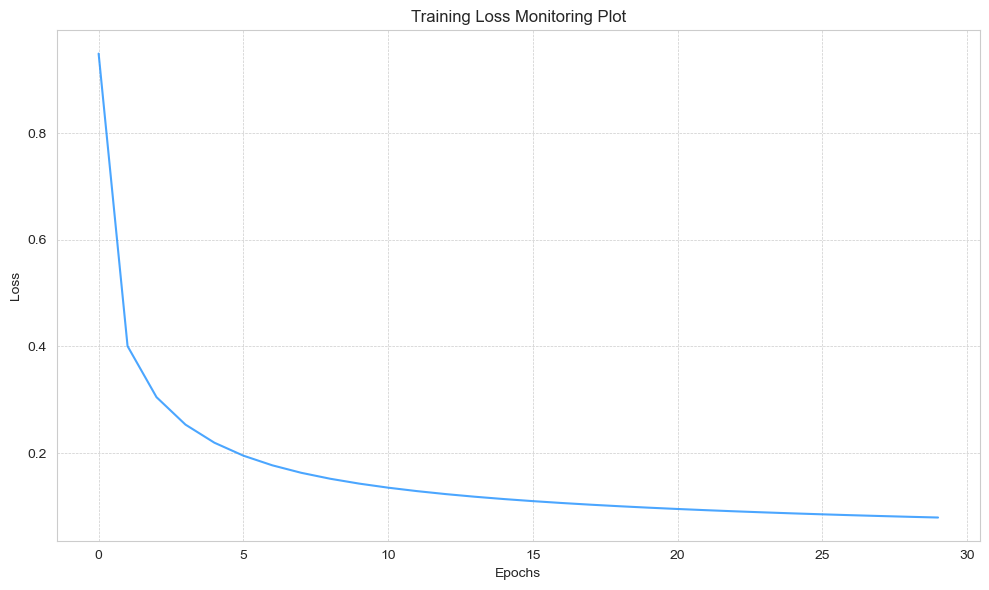

In [223]:
# Plot the training loss curve
# After training, plot the losses to visualize the training process
# TODO: Implement the function to plot the loss curve
plt.figure(figsize=(10, 6), dpi=100)
sns.set_style('whitegrid')

plt.plot(np.arange(epochs), losses, color='#1E90FF', alpha=0.8)

plt.title('Training Loss Monitoring Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

## Evaluation

We can measure the models accuracy on the test dataset.

In [224]:
# Test the model
# Use the trained model to make predictions on the test data (x_test)
# TODO: Apply the model on x_test to get predictions
logits = model(x_test)
y_pred_test = np.argmax(logits, axis=1)

# Calculate the accuracy by comparing the predicted labels (y_prediction) with the true labels (y_test)
# TODO: Compute the accuracy of the predictions
acc = np.sum(y_pred_test == y_test) / y_pred_test.shape[0]
# Print the test accuracy
# The message will include the number of training examples and test samples, and the calculated accuracy
print(f'Test accuracy with {len(y_train)} training examples on {len(y_test)} test samples is {acc:.2f}%')


Test accuracy with 11000 training examples on 10000 test samples is 0.98%


The confusion matrix can also be observed:

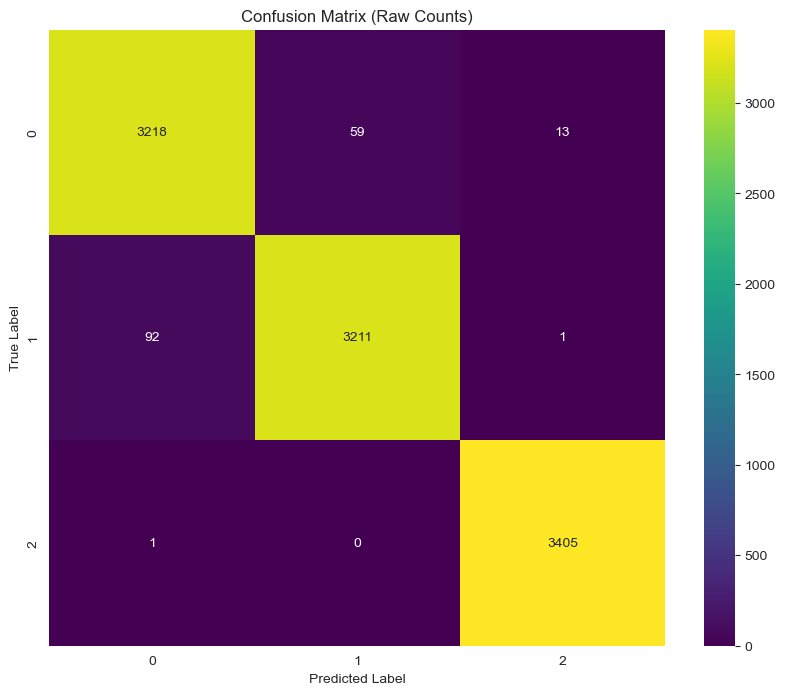

In [226]:
# Plot the confusion matrix
#TODO
conf_mat = confusion_matrix(y_test, y_pred_test)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap='viridis', 
            square=True)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()